In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# File paths
Cleanfile = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"


# Data types specification
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}

# Load data
df_clean = pd.read_csv(Cleanfile, dtype=dtype_spec, low_memory=False)
drop =["Unnamed: 0","Em_on_target"]
df_clean = df_clean.drop(drop, axis=1)

#df_clean.drop_duplicates(inplace=True)

In [14]:
#df_clean.info()

In [15]:
# Encode categorical variables
#label_encoders = {}
#for column in df_clean.select_dtypes(include=['category']).columns:
    #label_encoders[column] = LabelEncoder()
    #df_clean[column] = label_encoders[column].fit_transform(df_clean[column])

# Display the first few rows to verify
#df_clean.head()

In [16]:
# Define the features for each energy type
features_dict = {
    'petrol': ['Fuel consumption', 'Wheelbase_mm', 'Engine_cm3', 'Power_KW', 'Axle_width_steer_mm', 
               'Test_mass', 'Axle_width_other_mm', 'Eco-innovation program', 'Kg_veh', 'year', 
               'Erwltp (g/km)', 'El_Consumpt_whkm'],
    'diesel': ['Wheelbase_mm', 'Axle_width_other_mm', 'Power_KW', 'Test_mass', 'Axle_width_steer_mm', 
               'Kg_veh', 'Engine_cm3', 'Fuel consumption', 'year', 'Erwltp (g/km)', 'Eco-innovation program', 
               'El_Consumpt_whkm'],
    'lpg': ['Kg_veh', 'Fuel consumption', 'Axle_width_steer_mm', 'Axle_width_other_mm', 'year', 'Test_mass', 
            'Power_KW', 'Erwltp (g/km)', 'Engine_cm3', 'Wheelbase_mm', 'Eco-innovation program', 
            'Electric range (km)'],
    'hybrid petrol': ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
                     'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
                     'Eco-innovation program', 'Test_mass', 'Kg_veh'],
    'hybrid diesel': ['El_Consumpt_whkm', 'Axle_width_other_mm', 'Electric range (km)', 'Axle_width_steer_mm', 
                     'year', 'Kg_veh', 'Test_mass', 'Fuel consumption', 'Wheelbase_mm', 'Eco-innovation program', 
                     'Erwltp (g/km)', 'Power_KW']
}

In [17]:
# Function to prepare data for regression
def prepare_data(df, energy_types, features_dict):
    if isinstance(energy_types, list):
        dfs = []
        for energy in energy_types:
            df_energy = df[df['Energy'] == energy].copy()
            if df_energy.empty:
                print(f"No data for energy type: {energy}")
                continue
            df_energy = df_energy[features_dict[energy] + ['CO2_wltp']]
            dfs.append(df_energy)
        if not dfs:
            return pd.DataFrame(), pd.Series(), []
        df_combined = pd.concat(dfs, axis=0)
        features = [feat for energy in energy_types for feat in features_dict[energy]]
        features = list(set(features))  # Remove duplicates
    else:
        df_combined = df[df['Energy'] == energy_types].copy()
        if df_combined.empty:
            print(f"No data for energy type: {energy_types}")
            return pd.DataFrame(), pd.Series(), []
        features = features_dict[energy_types]
    
    X = df_combined[features]
    y = df_combined['CO2_wltp']
    
    return X, y, features

In [18]:
# Ridge Regression function with RandomizedSearchCV and enhanced visualization
def ridge_regression_with_random_search(df, energy_types, features_dict, alphas):
    # Prepare data
    X, y, feature_names = prepare_data(df, energy_types, features_dict)
    
    if X.empty or y.empty:
        print(f"No data available for energy types: {energy_types}")
        return None, None, None
    
    # Handle missing values
    X = X.fillna(X.mean())  # Avoid SettingWithCopyWarning
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Dimensionality Reduction
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_pca = pca.fit_transform(X_scaled)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    # Parameter grid for alpha
    param_grid = {'alpha': alphas}
    
    # Ridge Regression with RandomizedSearchCV
    ridge = Ridge()
    random_search = RandomizedSearchCV(ridge, param_distributions=param_grid, n_iter=100, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Best model
    best_ridge = random_search.best_estimator_
    best_alpha = random_search.best_params_['alpha']
    
    # Predictions with best model
    y_pred_best = best_ridge.predict(X_test)
    
    # Evaluation of best model
    best_r2 = r2_score(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    
    # Results reporting
    print(f"Energy Type: {'All' if isinstance(energy_types, list) else energy_types}")
    print(f"Best Alpha: {best_alpha}")
    print(f"Best R^2 Score: {best_r2}")
    print(f"Mean Squared Error: {mse_best}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter plot of actual vs predicted for best model
    sns.scatterplot(x=y_test, y=y_pred_best, ax=axes[0])
    axes[0].set_xlabel('Actual CO2_wltp')
    axes[0].set_ylabel('Predicted CO2_wltp')
    axes[0].set_title(f'Regression Results for {"All Energies" if isinstance(energy_types, list) else energy_types}')
    
    # R^2 scores vs alpha plot
    results_df = pd.DataFrame(random_search.cv_results_)
    sns.lineplot(x='param_alpha', y='mean_test_score', data=results_df, ax=axes[1])
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Mean CV R^2 Score')
    axes[1].set_title('Mean CV R^2 Score vs Alpha')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance for best model
    original_feature_importances = np.dot(pca.components_.T, best_ridge.coef_)
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.abs(original_feature_importances)})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    print("Feature Importances:")
    for feature, coef in zip(coef_df['Feature'], coef_df['Coefficient']):
        print(f"{feature}: {coef}")
    
    # Visualization of feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()
    
    return best_ridge, best_r2, mse_best

Energy Type: petrol
Best Alpha: 6.135907273413176
Best R^2 Score: 0.6281734409117675
Mean Squared Error: 128.76127891811478


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


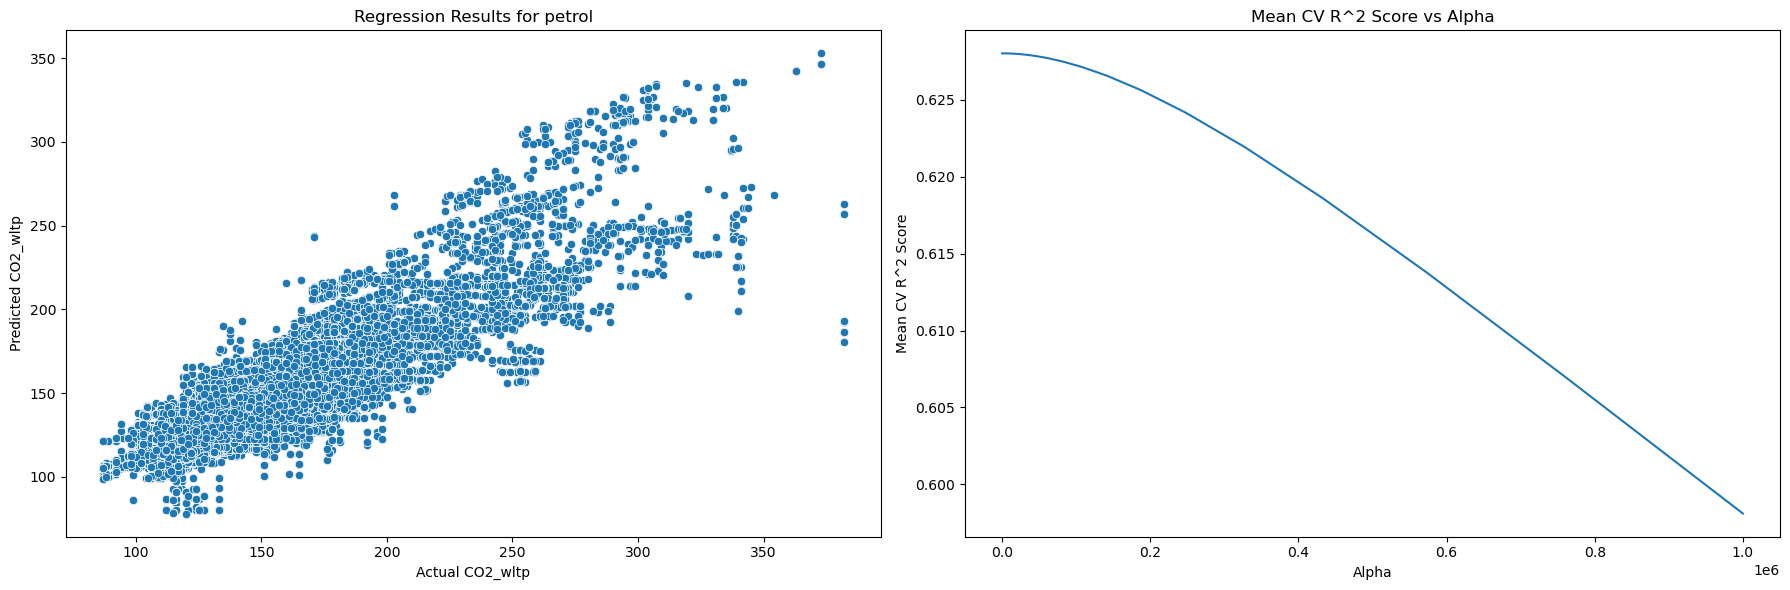

Feature Importances:
year: 8.895818665825555
Power_KW: 8.501762425412403
Fuel consumption: 5.902632907667974
Wheelbase_mm: 1.171565606983505
Test_mass: 1.158654120954804
Eco-innovation program: 0.8282351623485105
Axle_width_other_mm: 0.6169048379516315
Erwltp (g/km): 0.3069615443391025
El_Consumpt_whkm: 0.29713411047280436
Kg_veh: 0.2094214533250529
Engine_cm3: 0.20043703757225606
Axle_width_steer_mm: 0.17722018307277332


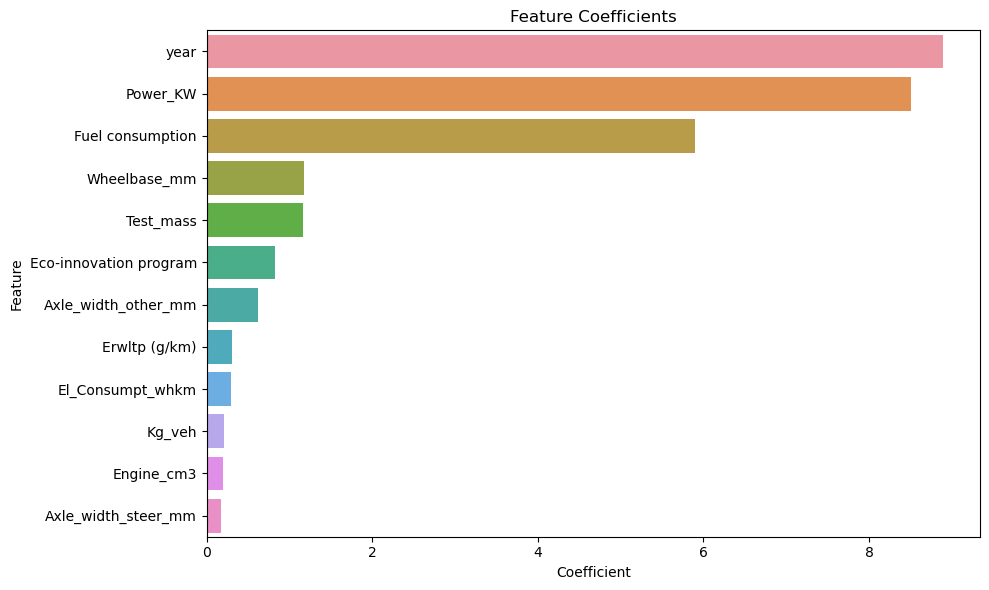

Energy Type: diesel
Best Alpha: 18.738174228603867
Best R^2 Score: 0.7961175716849654
Mean Squared Error: 94.86905826553651


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


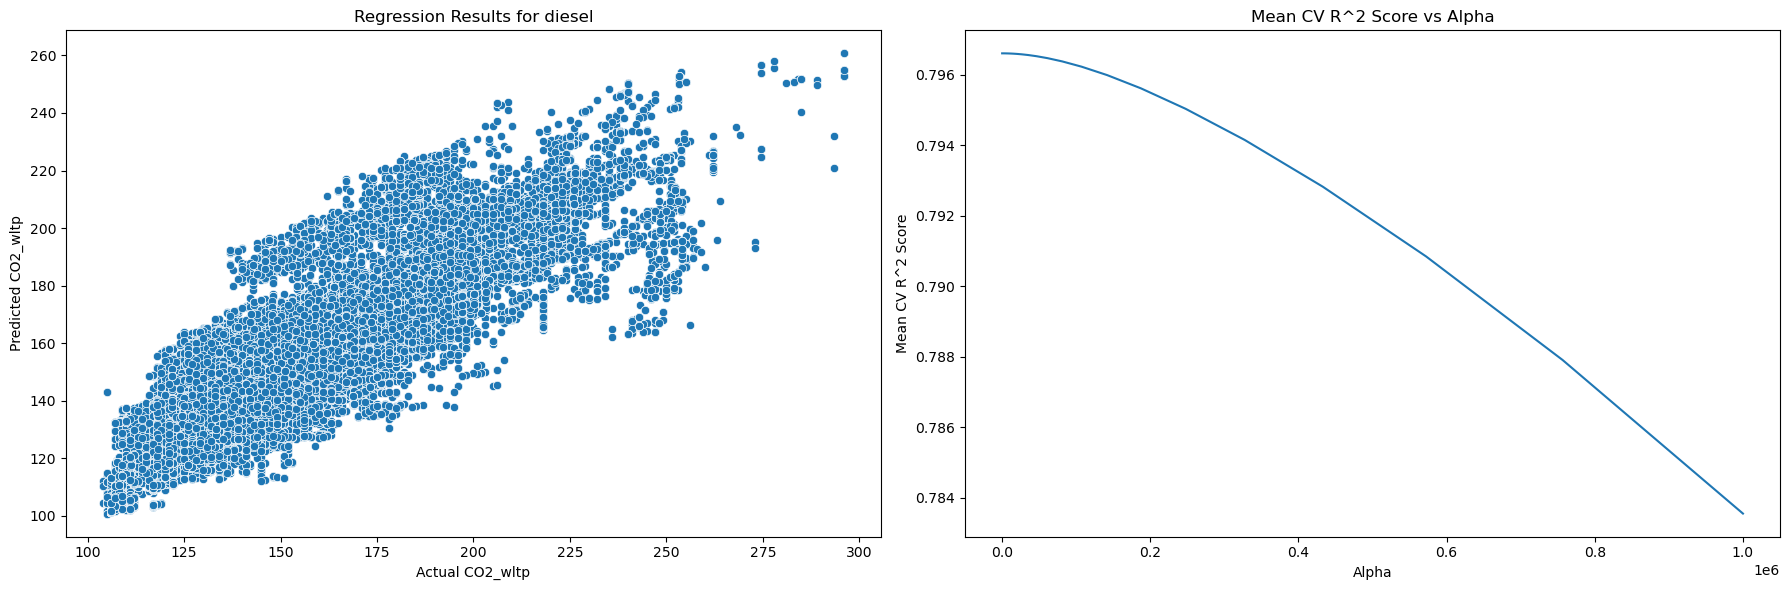

Feature Importances:
Test_mass: 4.061003870669811
Engine_cm3: 3.8337028126126285
Kg_veh: 3.781163803818178
year: 3.7764018494853127
Power_KW: 3.2353895910704775
Wheelbase_mm: 3.0527549005530665
Fuel consumption: 2.7225762003437195
Eco-innovation program: 2.4134633787370015
Axle_width_other_mm: 2.388815018966764
Axle_width_steer_mm: 1.136034094216025
Erwltp (g/km): 0.9133248368735979
El_Consumpt_whkm: 0.03484931574254739


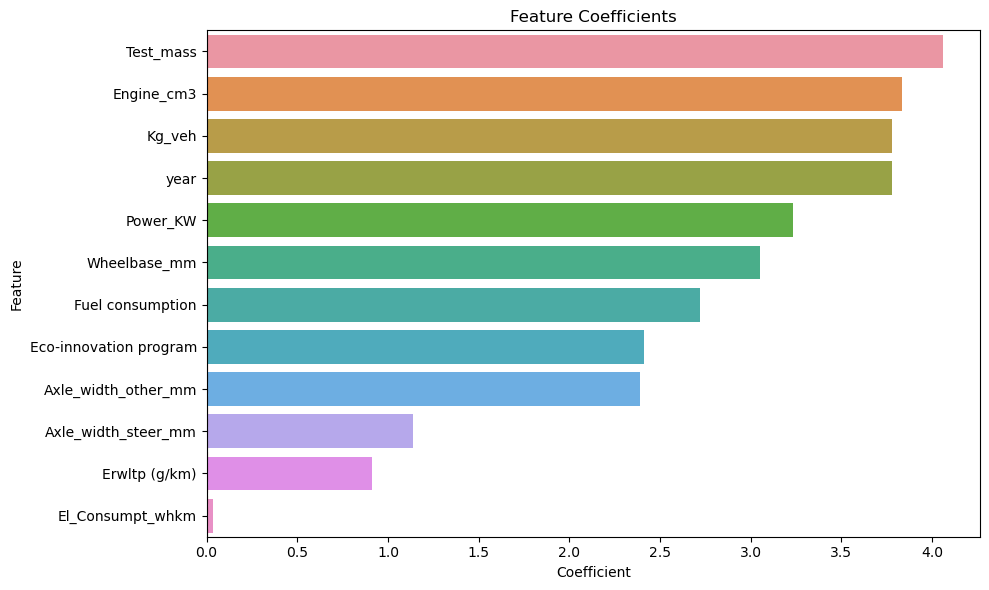

Energy Type: lpg
Best Alpha: 32.745491628777316
Best R^2 Score: 0.7695766388799473
Mean Squared Error: 16.41451223874335


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


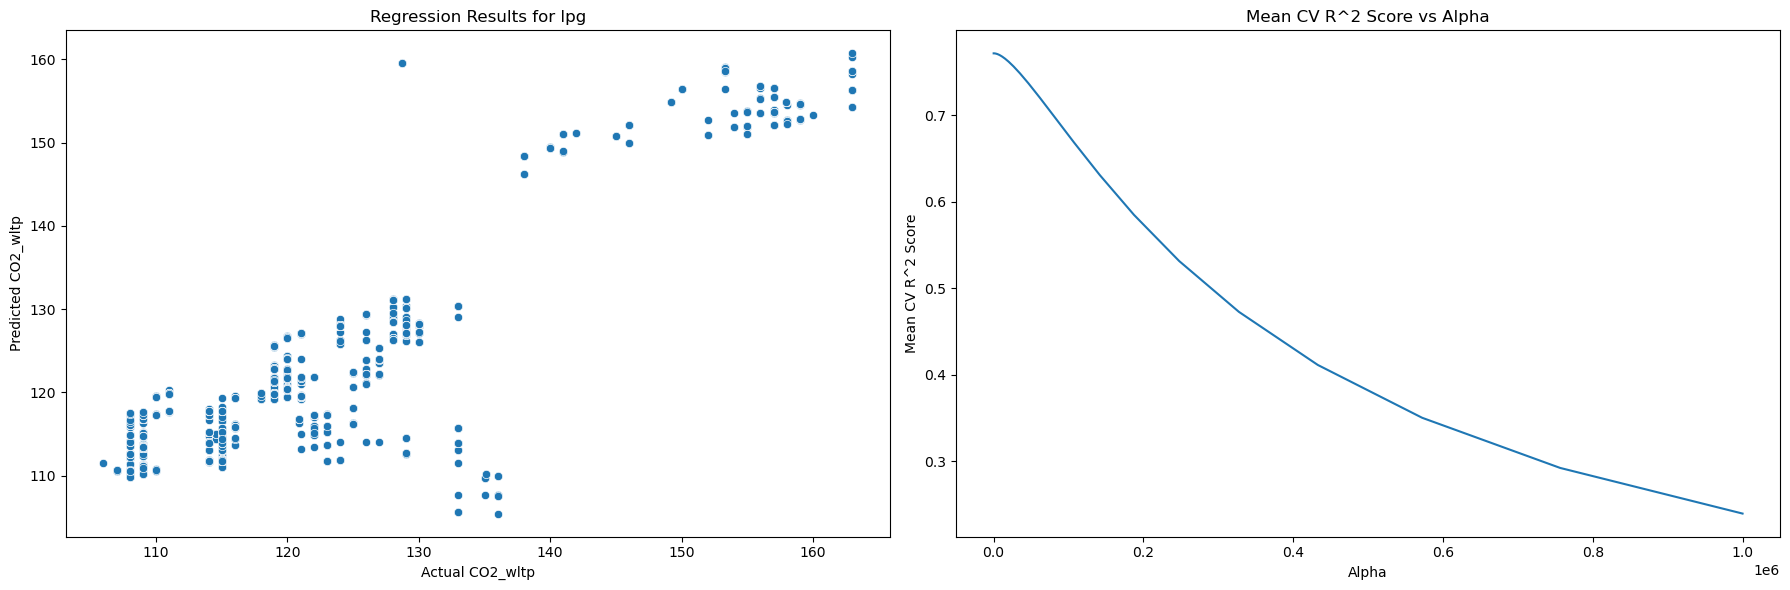

Feature Importances:
Engine_cm3: 3.0310156900345797
Test_mass: 1.9073121048269852
year: 1.8468610450499998
Kg_veh: 1.6075213360809002
Wheelbase_mm: 1.1216582661869223
Erwltp (g/km): 1.0926035336708166
Power_KW: 0.948106571367239
Eco-innovation program: 0.6214632312124051
Axle_width_other_mm: 0.6006600415777841
Axle_width_steer_mm: 0.5163094333999745
Fuel consumption: 0.2996246196168857
Electric range (km): 0.0


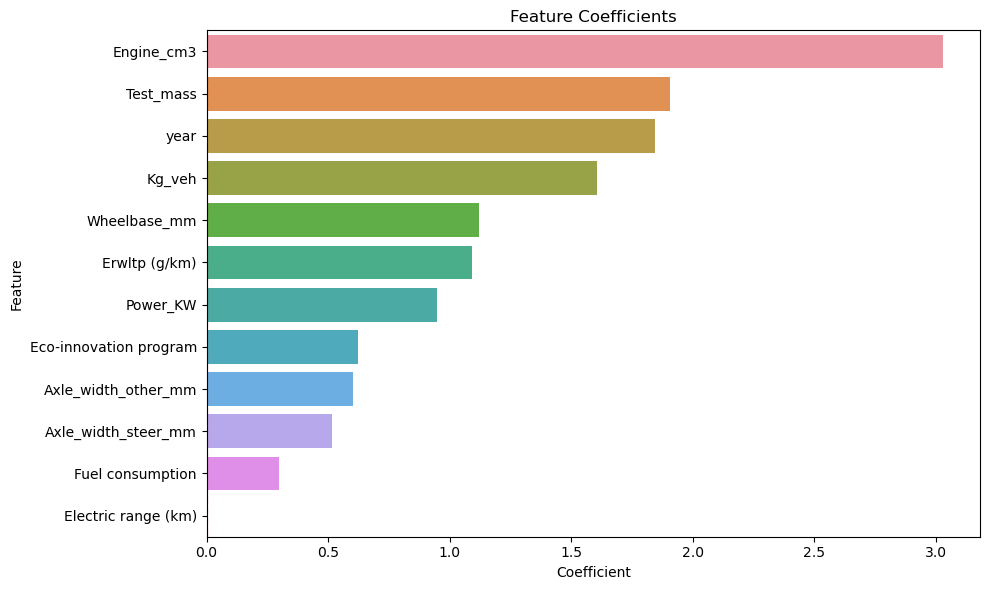

Energy Type: hybrid petrol
Best Alpha: 305.38555088334124
Best R^2 Score: 0.37699567521801125
Mean Squared Error: 187.23034361515454


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


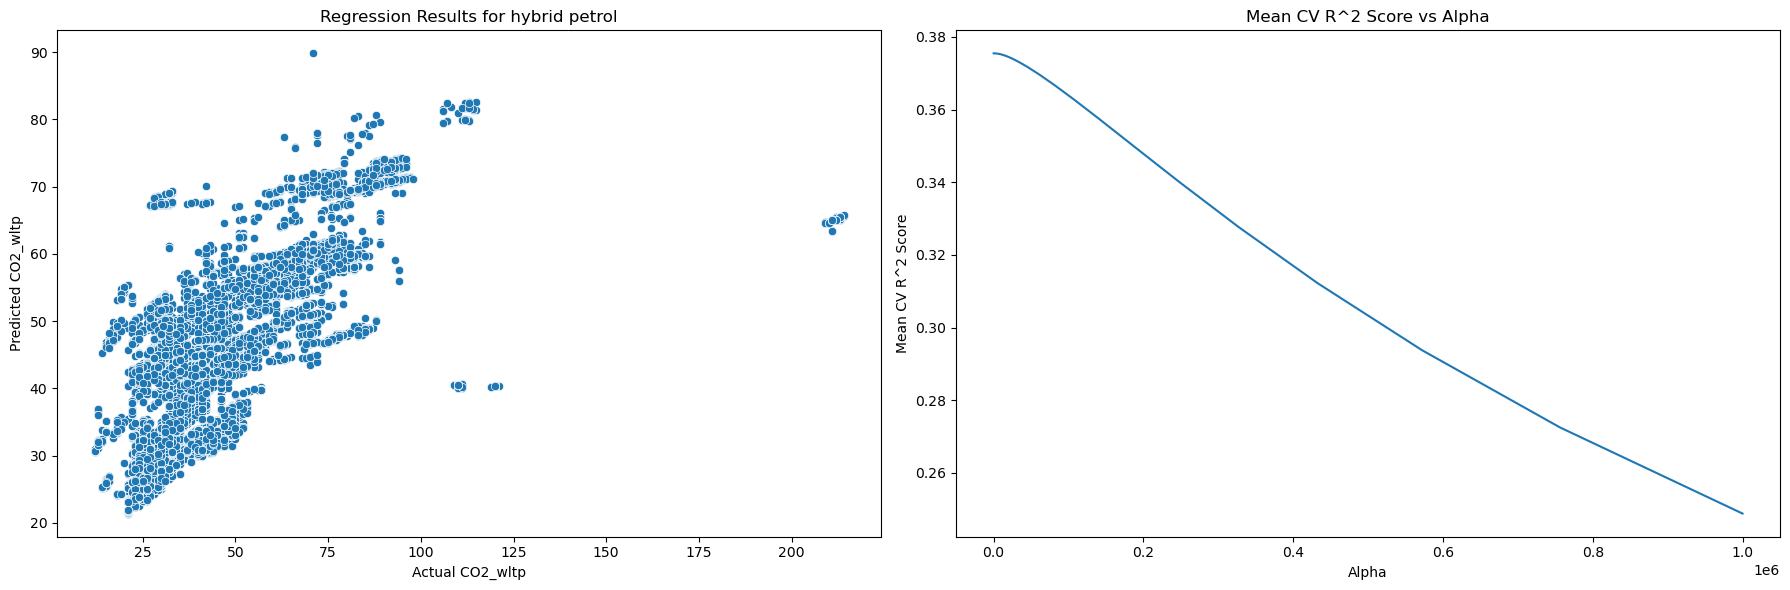

Feature Importances:
Fuel consumption: 5.913217301826999
Engine_cm3: 1.9022509792230435
year: 1.5656260436889073
El_Consumpt_whkm: 1.3368235621464846
Electric range (km): 1.3026290159189369
Test_mass: 1.1582850138527587
Kg_veh: 1.1133280215411605
Axle_width_other_mm: 0.9892779577268047
Power_KW: 0.8327329146657494
Axle_width_steer_mm: 0.8196658021543495
Eco-innovation program: 0.21277230313884288
Wheelbase_mm: 0.1044893357773915


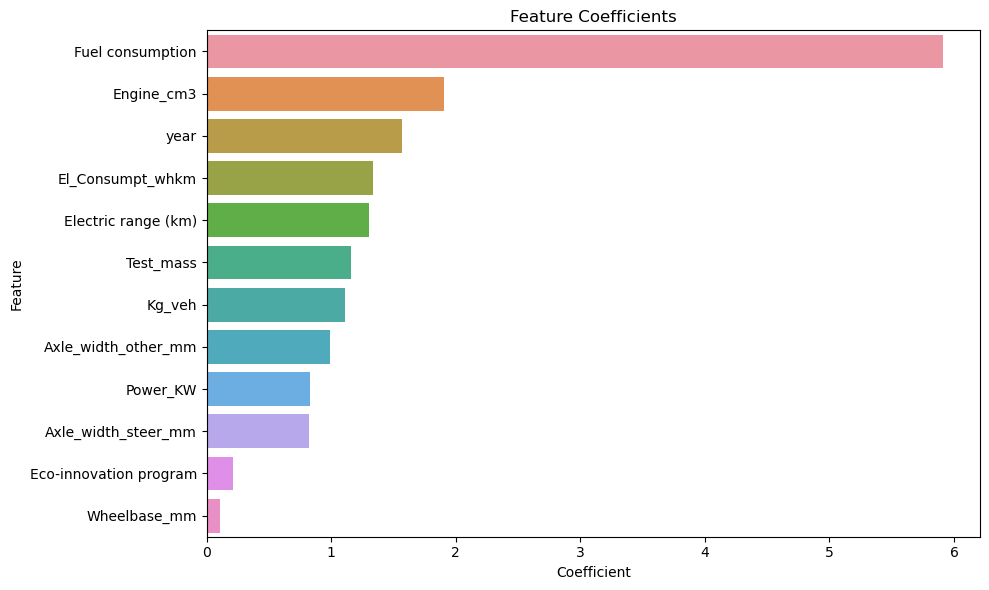

Energy Type: hybrid diesel
Best Alpha: 1.5199110829529332
Best R^2 Score: 0.9141724155309463
Mean Squared Error: 15.07492296682153


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


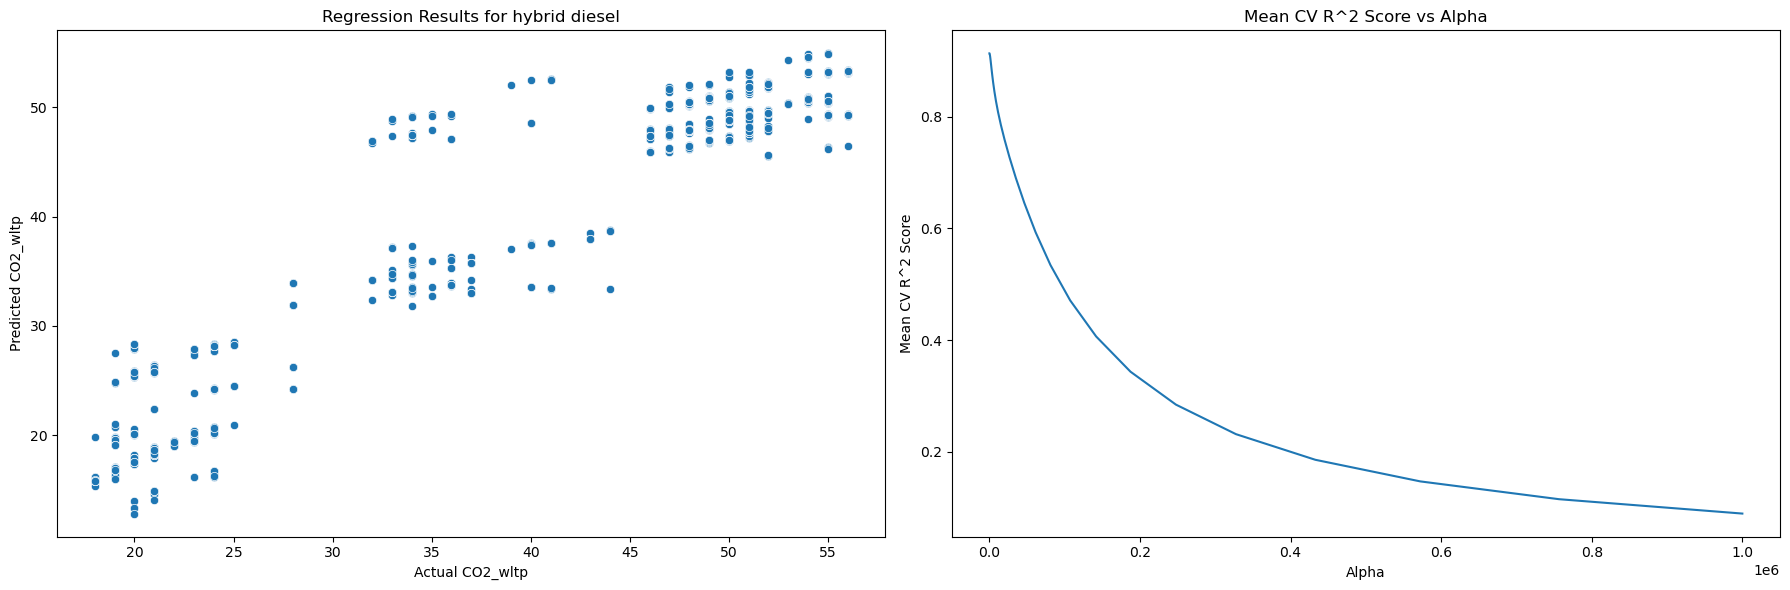

Feature Importances:
Wheelbase_mm: 6.438945975095074
Electric range (km): 4.768303683954844
El_Consumpt_whkm: 3.23119915330454
year: 2.783972502284986
Fuel consumption: 2.0418764969078254
Kg_veh: 1.6779139181351126
Test_mass: 1.222515799407666
Axle_width_steer_mm: 0.970167480362201
Axle_width_other_mm: 0.6153568076986815
Eco-innovation program: 0.0
Erwltp (g/km): 0.0
Power_KW: 0.0


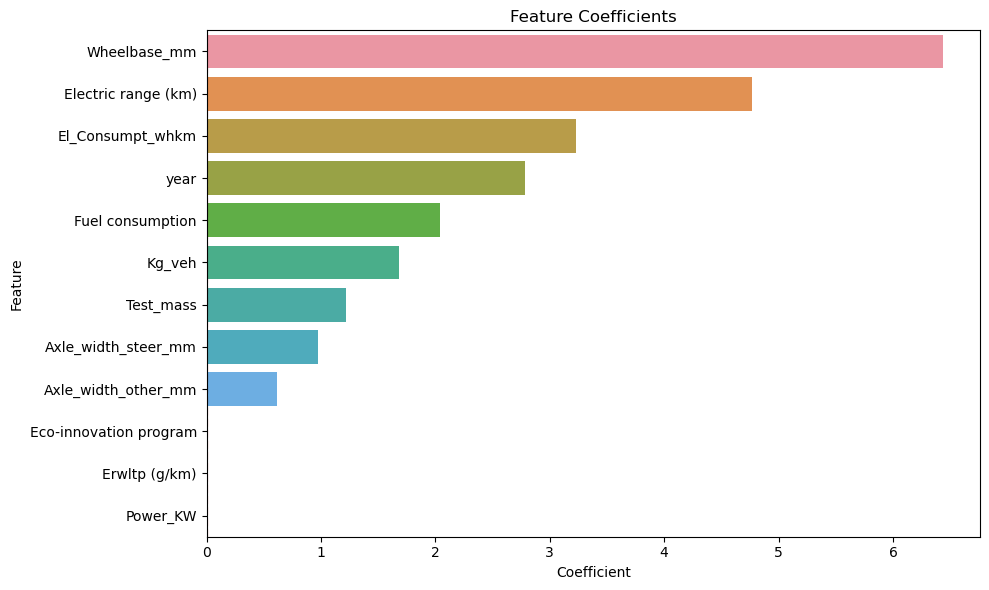

In [23]:
# Apply Ridge Regression for each energy type and all together with enhanced visualization
alphas = np.logspace(-6, 6, 100)
results = {}
for energy, features in features_dict.items():
    results[energy] = ridge_regression_with_random_search(df_clean, energy, features_dict, alphas)

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Energy Type: All
Best Alpha: 0.16297508346206435
Best R^2 Score: 0.7156168412866274
Mean Squared Error: 212.87970951522365


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


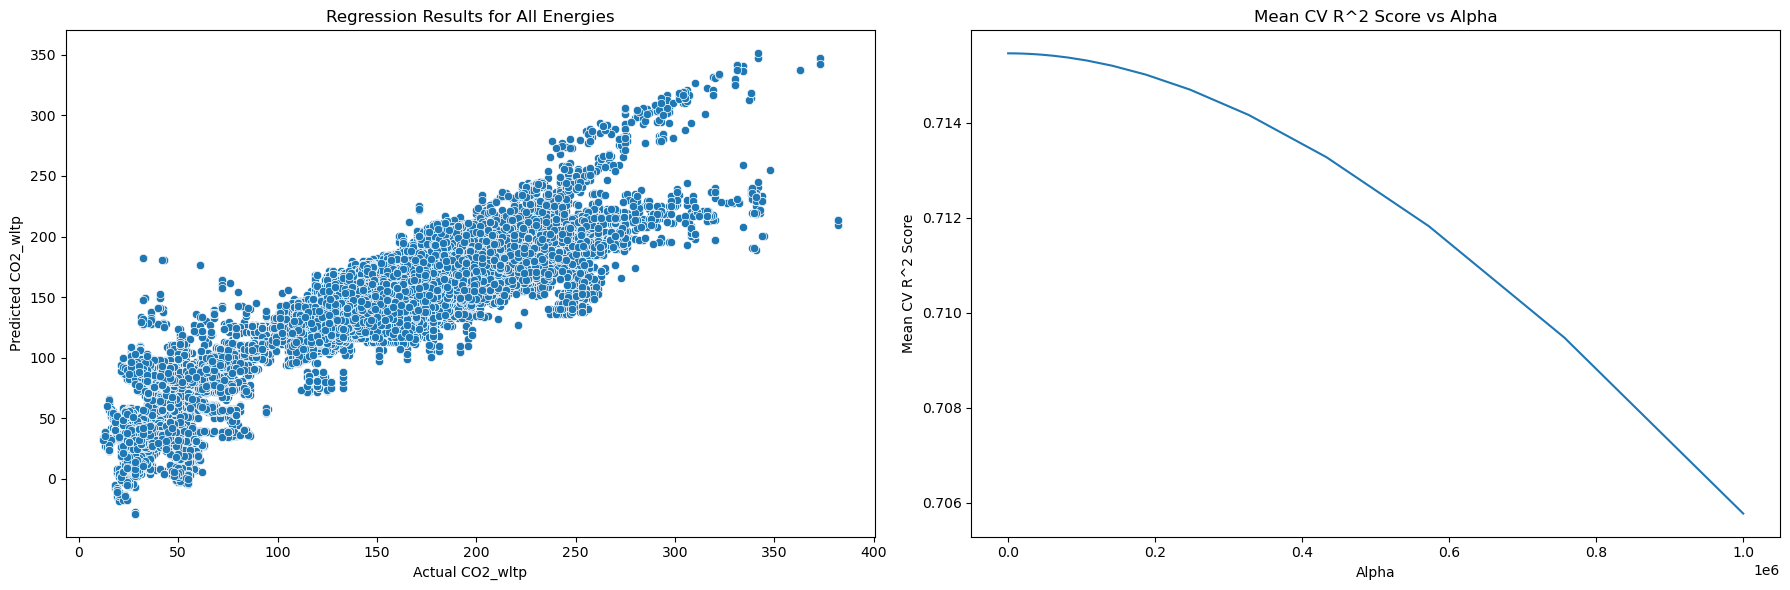

Feature Importances:
El_Consumpt_whkm: 13.530138985562393
Fuel consumption: 10.734998050492127
year: 5.8647876502428975
Engine_cm3: 5.315458083020931
Wheelbase_mm: 2.727405417391863
Power_KW: 2.6026887679419293
Axle_width_other_mm: 2.196291159494472
Electric range (km): 1.8067688296162008
Axle_width_steer_mm: 1.2358421231106382
Erwltp (g/km): 1.079058140412131
Test_mass: 0.5792292595234866
Kg_veh: 0.181552288418192
Eco-innovation program: 0.061664401115034774


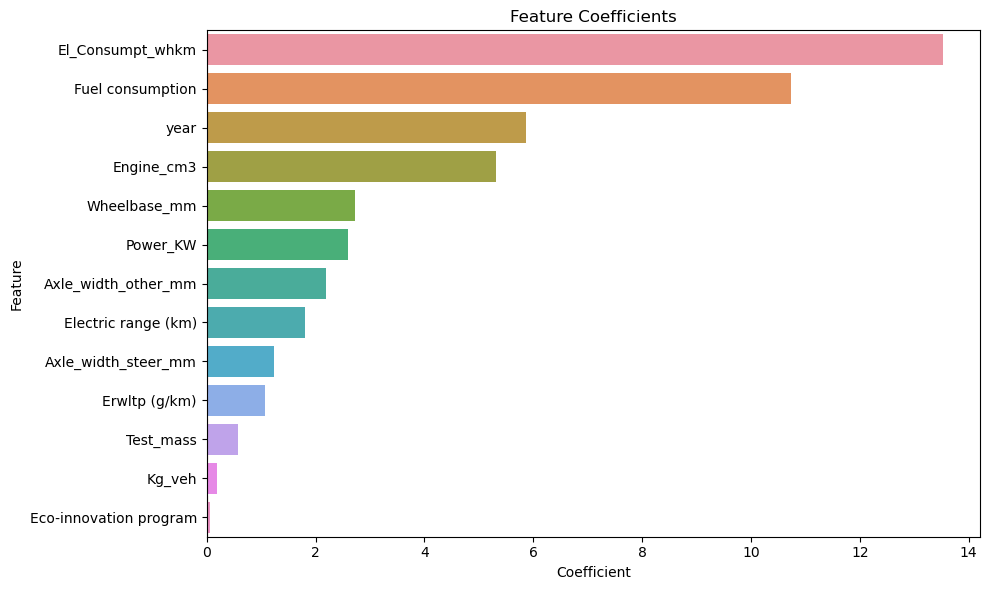

In [26]:
# Run regression on all energies together
all_energies = list(features_dict.keys())
results['all_energies'] = ridge_regression_with_random_search(df_clean, all_energies, features_dict, alphas)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


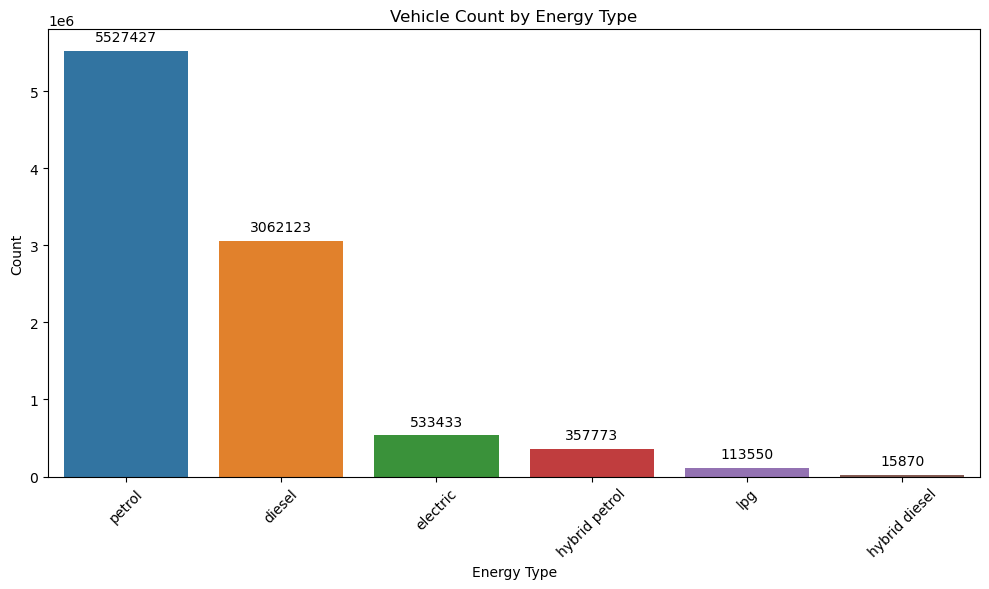

In [30]:
# Assuming df_Clean has been loaded as per the previous context
# Visualize vehicle count by Energy
def visualize_vehicle_count_by_energy(df):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x='Energy', order=df['Energy'].value_counts().index)
    
    # Add count labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
    
    plt.title('Vehicle Count by Energy Type')
    plt.xlabel('Energy Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_vehicle_count_by_energy(df_clean)